#### Prototype of the unified faeture-environment extraction with a fixed box size

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
import cartopy.crs as ccrs
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def coordinates_processors(data):
    """ 
    converting longitude/latitude into lon/lat 
    data: xarray.dataset coordinated horizontally in lat/lon
    """

    coord_names = []
    for coord_name in data.coords:
        coord_names.append(coord_name)

    if (set(coord_names) & set(['longitude','latitude'])): # if coordinates set this way...

        data2 = data.rename({'latitude': 'lat'})
        data2 = data2.rename({'longitude': 'lon'})
    else:
        data2 = data

    # check if latitutde is decreasing
    if (data2.lat[1] - data2.lat[0]) < 0:
        data2 = data2.reindex(lat=list(reversed(data2.lat))) # flipping latitude accoordingly

    return data2

In [4]:
class ds_feature_environment:
    
    __version__ = "1.0beta"
    
    def __init__(self):
        self.track_data = None                    # xarray dataset 
        self.object_data = None                   # xarray dataset 
        self.env_data = None                      # xarray dataset
        self.feature_data_sources = None          # e.g., ERA5, GPM-IMERG+MERGE-IR
        self.environmental_data_sources = None    # e.g., ERA5
        self.track_frequency = None               # hourly
        self.env_frequency = None                 # hourly
    
    def load_track_data(self, file_path):
        self.track_data = xr.open_dataset(file_path)
        
        return self.track_data
    
    def load_object_data(self, file_path):
        self.object_data = xr.open_dataset(file_path)
        
        return self.track_data

    def locate_env_data(self, variable_name, path_dir):
        self.locate_env_data = {}
        
        if len(self.locate_env_data) == 0:
            self.locate_env_data[variable_name] = path_dir            
            
    def locate_feature_data(self, data_dict, path_dir=True):
        self.locate_feature_data = {}
        
        if len(self.locate_feature_data) == 0:
            self.locate_feature_data[variable_name] = path_dir    
            
    def get_track_info(self, track_number):
        
        track_info = self.track_data.sel(tracks=track_number)
        
        return track_info
    
    def get_object_info(self, object_id):
        
        obj_info = self.object_data.sel(object_id=object_id)
        
        return obj_info
    
    def get_environment_vars_track(self, track_id, lat_range, lon_range, p_level=None):
        
        if len(self.locate_env_data) == 0:
            raise ValueError("No environmental data located. Please call locate_env_data() first")
        
        else:
            
            track_info = self.get_track_info(track_number=track_id)
             
            lat_cen = track_info.meanlat.values # MCS lat centroid
            lon_cen = track_info.meanlon
            lon_cen = lon_cen.where(lon_cen >= 0, lon_cen+360) # converting to 0-360
            lon_cen = lon_cen.values
            
            # find out when the tracked MCS ends as indicated by NaT
            idx_end = np.where(np.isnat(track_info.base_time.values))[0][0] 

            data_chunk = []
                        
            for t in range(idx_end):

                time64 = track_info.base_time[t].values
                timestamp = (time64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
                time_sel = datetime.utcfromtimestamp(timestamp)
            
                # determine the env_data to be loaded            
                year = str(time_sel.year)
                month = str(time_sel.month).zfill(2)
                day = str(time_sel.day).zfill(2)
                hour = str(time_sel.hour).zfill(2)

                data_var = []
                for var in [i for i in self.locate_env_data.keys()]:
                    
                    filename = Path('/neelin2020/ERA-5/NC_FILES') /'{}'.format(year)/ 'era-5.{}.{}.{}.nc'.format(var,year,month)
                    data_file = xr.open_dataset(filename)
                    data_file = coordinates_processors(data_file)
                    
                    # find nearest ERA5 grid for the MCS centroid
                    idx_sel = np.argmin(np.abs(data_file.lon.values - lon_cen[t]))
                    lon_cen_reset = data_file.lon[idx_sel]
                    idx_sel = np.argmin(np.abs(data_file.lat.values - lat_cen[t]))
                    lat_cen_reset = data_file.lat[idx_sel]
                
                    lat_min = lat_cen_reset - lat_range//2
                    lat_max = lat_cen_reset + lat_range//2
                    lon_min = lon_cen_reset - lon_range//2
                    lon_max = lon_cen_reset + lon_range//2
                
                    data_extract = data_file.sel(lat=slice(lat_min, lat_max),
                                                        lon=slice(lon_min, lon_max))
                    data_extract = data_extract.sel(time=time_sel, method='nearest')
                    
                    # x-y grid poiints coordinate not lat-lon 
                    dlon = (data_file.lon[1] - data_file.lon[0]).values
                    dlat = (data_file.lat[1] - data_file.lat[0]).values
                    data_extract_xy = data_extract.interp(lon=np.linspace(data_extract.lon.min(), data_extract.lon.max(),int(lon_range/dlon)+1),
                                              lat=np.linspace(data_extract.lat.min(), data_extract.lat.max(),int(lat_range/dlat)+1))
                    # converting lat-lon into x-y coordinates
                    data_extract_xy = data_extract_xy.assign_coords(x=("lon", np.arange(len(data_extract_xy.lon))), y=("lat", np.arange(len(data_extract_xy.lat))))
                    data_extract_xy = data_extract_xy.swap_dims({'lon':'x', 'lat': 'y'})

                    if p_level is not None: # for 3-D data ERA5 only, with vertical dim. named "level"

                        data_extract_xy = data_extract_xy.sel(level=p_level) # update data_extract which is single layer
                            
                    data_var.append(data_extract_xy)
                data_var_tmerged = xr.merge(data_var) # merge variables into one xr.dataset
                data_chunk.append(data_var_tmerged)
                                   
            return xr.concat(data_chunk, dim='time')
        
    def get_environment_vars_single(self, object_id, lat_range, lon_range, p_level=None):
        
        if len(self.locate_env_data) == 0:
            raise ValueError("No environmental data located. Please call locate_env_data() first")
        
        else:
            
            obj_info = self.get_object_info(object_id=object_id)
        
            lat_cen = obj_info.meanlat.values # MCS lat centroid
            lon_cen = obj_info.meanlon
            lon_cen = lon_cen.where(lon_cen >= 0, lon_cen+360) # converting to 0-360
            lon_cen = lon_cen.values

            data_chunk = []
                        
            time64 = obj_info.base_time.values
            timestamp = (time64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
            time_sel = datetime.utcfromtimestamp(timestamp)

            # determine the env_data to be loaded            
            year = str(time_sel.year)
            month = str(time_sel.month).zfill(2)
            day = str(time_sel.day).zfill(2)
            hour = str(time_sel.hour).zfill(2)

            data_var = []
            for var in [i for i in self.locate_env_data.keys()]:

                filename = Path('/neelin2020/ERA-5/NC_FILES') /'{}'.format(year)/ 'era-5.{}.{}.{}.nc'.format(var,year,month)
                data_file = xr.open_dataset(filename)
                data_file = coordinates_processors(data_file)

                # find nearest ERA5 grid for the MCS centroid
                idx_sel = np.argmin(np.abs(data_file.lon.values - lon_cen))
                lon_cen_reset = data_file.lon[idx_sel]
                idx_sel = np.argmin(np.abs(data_file.lat.values - lat_cen))
                lat_cen_reset = data_file.lat[idx_sel]

                lat_min = lat_cen_reset - lat_range//2
                lat_max = lat_cen_reset + lat_range//2
                lon_min = lon_cen_reset - lon_range//2
                lon_max = lon_cen_reset + lon_range//2

                data_extract = data_file.sel(lat=slice(lat_min, lat_max),
                                                    lon=slice(lon_min, lon_max))
                data_extract = data_extract.sel(time=time_sel, method='nearest')

                # x-y grid poiints coordinate not lat-lon 
                dlon = (data_file.lon[1] - data_file.lon[0]).values
                dlat = (data_file.lat[1] - data_file.lat[0]).values
                data_extract_xy = data_extract.interp(lon=np.linspace(data_extract.lon.min(), data_extract.lon.max(),int(lon_range/dlon)+1),
                                          lat=np.linspace(data_extract.lat.min(), data_extract.lat.max(),int(lat_range/dlat)+1))
                # converting lat-lon into x-y coordinates
                data_extract_xy = data_extract_xy.assign_coords(x=("lon", np.arange(len(data_extract_xy.lon))), y=("lat", np.arange(len(data_extract_xy.lat))))
                data_extract_xy = data_extract_xy.swap_dims({'lon':'x', 'lat': 'y'})

                if p_level is not None: # for 3-D data ERA5 only, with vertical dim. named "level"

                    data_extract_xy = data_extract_xy.sel(level=p_level) # update data_extract which is single layer

                data_var.append(data_extract_xy)
            data_var_merged = xr.merge(data_var) # merge variables into one xr.dataset
                                   
        return data_var_merged
        
    def get_feature_vars_track(self, track_id, lat_range, lon_range):
        
        if self.feature_data is None:
            raise ValueError("No feature data loaded. Please call load_feature_data() first")
        
        else:
            track_info = mc.get_track_info(track_number=track_id)

            lat_cen = track_info.meanlat.values # MCS lat centroid
            lon_cen = track_info.meanlon.values

            # find out when the tracked MCS ends as indicated by NaT
            idx_end = np.where(np.isnat(track_info.base_time.values))[0][0] 
            
            data_chunk = []
                        
            for t in range(idx_end):

                time64 = track_info.base_time[t].values
                timestamp = (time64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
                time_sel = datetime.utcfromtimestamp(timestamp)
                
                # find nearest ERA5 grid for the MCS centroid
                
                idx_sel = np.argmin(np.abs(mc.env_data[env_var_name].lon.values - lon_cen[t]))
                lon_cen_reset = mc.env_data[env_var_name].lon[idx_sel]
                idx_sel = np.argmin(np.abs(mc.env_data[env_var_name].lat.values - lat_cen[t]))
                lat_cen_reset = mc.env_data[env_var_name].lat[idx_sel]
                
                lat_min = lat_cen_reset - lat_range
                lat_max = lat_cen_reset + lat_range
                lon_min = lon_cen_reset - lon_range
                lon_max = lon_cen_reset + lon_range

                data_mcsid =  mc.feature_data[var_name].sel(time=time_sel, method='nearest')
                data_mcsid = data_mcsid.where(data_mcsid==track_id+1, 0)
                data_mcsid = data_mcsid.interp(lon = mc.env_data[env_var_name].lon, 
                                               lat = mc.env_data[env_var_name].lat) # interpolate into 0.25deg
                data_extract = data_mcsid.sel(lat=slice(lat_min, lat_max),
                                                    lon=slice(lon_min, lon_max))
                data_extract = data_extract.where(data_extract>0, 0) # exclude other MCSs in the scene
                data_extract = data_extract.where(data_extract==0, track_id+1).astype('float32') # fill back the tracknumber 
                    
                data_chunk.append(data_extract)
                
            return data_chunk

## Application 
- Paths of feature track and environmental variables
- Call module and save the dataset
- Plotting 

#### Call feature-environment module

In [5]:
# call the feature-environemnt module
featenv = ds_feature_environment()
print('version: ', featenv.__version__)
featenv.feature_data_sources = 'GPM-IMERG; MERGE-IR'
featenv.environmental_data_sources = 'ERA5'
featenv.track_frequency = 'hourly'
featenv.env_frequency = 'hourly'

print("Feature data sources:", featenv.feature_data_sources)
print("Environmental data sources:", featenv.environmental_data_sources)

# 1. locate environment variables: variable names, direct paths
T_dir = Path('/neelin2020/ERA-5/NC_FILES/')
q_dir = Path('/neelin2020/ERA-5/NC_FILES/') 
featenv.locate_env_data('T', T_dir)
featenv.locate_env_data.update({'q': q_dir})

print('Environmental data located: \n',featenv.locate_env_data)

version:  1.0beta
Feature data sources: GPM-IMERG; MERGE-IR
Environmental data sources: ERA5
Environmental data located: 
 {'T': PosixPath('/neelin2020/ERA-5/NC_FILES'), 'q': PosixPath('/neelin2020/ERA-5/NC_FILES')}


#### 1. feature tracks: MCS tracks as example 
(timestamps for each track, lat_centroid, lon_centroid)

In [6]:
# load feature track : global MCS tracks from FLEXTRKR in 2020 as example
track_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/')
track_data = featenv.load_track_data(track_dir / 'mcs_tracks_final_extc_20200101.0000_20210101.0000.nc')

# 2. a subset of MCSs over the tropical Indian Ocean (50-90, -10,10)
meanlon = track_data.meanlon.sel(times=0)
meanlat = track_data.meanlat.sel(times=0)
cond1 = (meanlon >= 50) & (meanlon <=90)
cond2 = (meanlat >= -10) & (meanlat <=10)
track_sub = np.intersect1d(np.where(cond1 == 1)[0], np.where(cond2 == 1)[0])

# update track_data with a small subset
featenv.track_data = track_data.isel(tracks=track_sub)
featenv.track_data

<xarray.Dataset> Size: 1GB
Dimensions:                  (tracks: 1727, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 14kB 13 89 115 ... 32127 32128 32131
  * times                    (times) int64 3kB 0 1 2 3 4 ... 395 396 397 398 399
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 7kB ...
    start_status             (tracks) float64 14kB ...
    end_status               (tracks) float64 14kB ...
    start_basetime           (tracks) datetime64[ns] 14kB ...
    end_basetime             (tracks) datetime64[ns] 14kB ...
    start_split_cloudnumber  (tracks) float64 14kB ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 6MB ...
    movement_distance        (tracks, times) float32 3MB ...
    movement_speed           (tracks, times) float32 3MB ...
    movement_theta           (tracks, times) float32 3MB ...
    movement_distance_x      (tracks, times) float32 3MB ...
    movement_distance_y      (tracks, times) float32 3MB ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Wed Mar  9 03:42:36 2022
    startdate:                   20200101.0000
    enddate:                     20210101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

#### use "get_environment_vars" and return the individual feature-env data

In [7]:
# extract feat-env data for individual tracks
ds_track_out = featenv.get_environment_vars_track(track_id=13, lat_range=10, lon_range=10)
ds_track_out

<xarray.Dataset> Size: 10MB
Dimensions:  (time: 14, level: 27, y: 41, x: 41)
Coordinates:
  * level    (level) int32 108B 100 125 150 175 200 225 ... 900 925 950 975 1000
  * time     (time) datetime64[ns] 112B 2020-01-01T01:00:00 ... 2020-01-01T14...
    lon      (time, x) float64 5kB 61.75 62.0 62.25 62.5 ... 67.25 67.5 67.75
    lat      (time, y) float64 5kB -14.0 -13.75 -13.5 -13.25 ... -5.0 -4.75 -4.5
  * x        (x) int64 328B 0 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40
  * y        (y) int64 328B 0 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40
Data variables:
    t        (time, level, y, x) float64 5MB 192.8 192.9 193.0 ... 299.5 299.6
    q        (time, level, y, x) float64 5MB 1.77e-06 1.77e-06 ... 0.01814
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-04 20:17:32 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

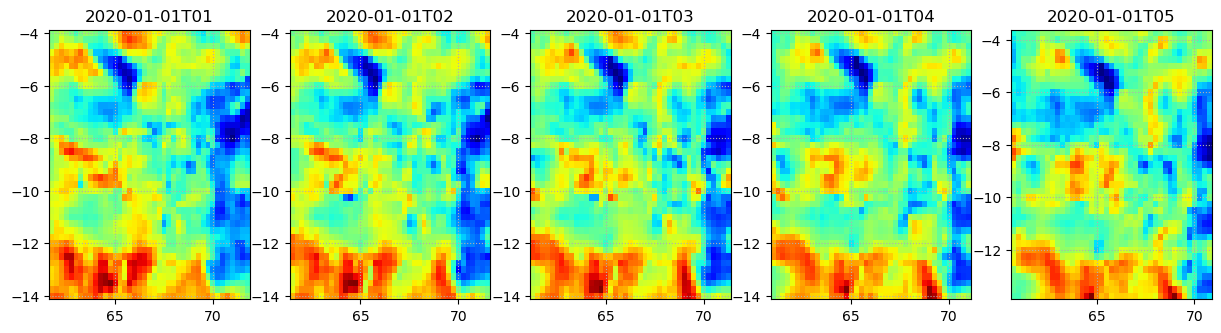

In [8]:
fig, ax = plt.subplots(1,5,figsize=(15,3.5))

# plotting the first 5 timesteps of the track No. 13
for i in range(5):
    ax[i].pcolormesh(ds_track_out.lon[i,:], ds_track_out.lat[i,:], ds_track_out.sel(level=1000).q[i,:,:],
                    cmap='jet')
    ax[i].set_title(str(ds_track_out.time[i].values)[:13])
    ax[i].grid(ls=':')
plt.show()

#### 2. feature objects: time, lat_centroid, lon_centroid
- e.g., co-occurring features 

In [9]:
# creating demo dataset (id, time, lat_centroid, lon_centroid)
obj_id = np.array([1,2])
base_time = np.array([datetime(2020,1,1,0),datetime(2020,1,1,0)])
meanlat = np.array([13.5, -10]) # lat of feature centroid
meanlon = np.array([50, 160])

feature_obj = xr.Dataset(data_vars=dict(
                         base_time=(['object_id'], base_time),
                         meanlon=(['object_id'], meanlon),    
                         meanlat=(['object_id'], meanlat)),
                         coords=dict(object_id = (['object_id'], obj_id)))

featenv.object_data = feature_obj
featenv.object_data

<xarray.Dataset> Size: 64B
Dimensions:    (object_id: 2)
Coordinates:
  * object_id  (object_id) int64 16B 1 2
Data variables:
    base_time  (object_id) datetime64[ns] 16B 2020-01-01 2020-01-01
    meanlon    (object_id) int64 16B 50 160
    meanlat    (object_id) float64 16B 13.5 -10.0

#### use "get_environment_vars" and return the individual feature-env data

In [10]:
# extract feat-env data for a single object
ds_obj_out = featenv.get_environment_vars_single(object_id=1, lat_range=10, lon_range=10)

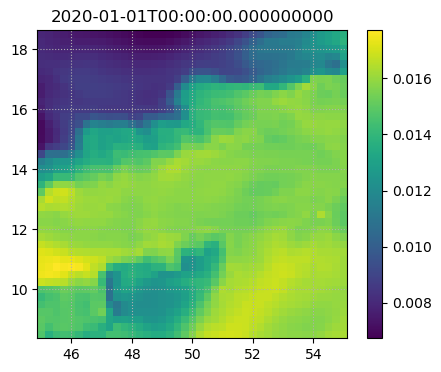

In [11]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
cp = ax.pcolormesh(ds_obj_out.lon, ds_obj_out.lat, ds_obj_out.sel(level=1000).q)
plt.colorbar(cp)
ax.set_title(ds_obj_out.time.values)
ax.grid(ls=':')
plt.show()

#### 3. Save datasets of individual feature tracks/feature objects 

In [12]:
out_dir = Path('/scratch/wmtsai/test_ground/')
ds_track_out.to_netcdf(out_dir / 'featenv_dataset.test.nc')